In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

from tqdm import tqdm
import glob
import pandas as pd

# ### 단일 파일 읽기
# file_path = 'feed_original_log_data.pickle'

# # log_data.pickle 파일을 읽어옴
# print(f"read {file_path} file.")

# df = pd.read_pickle(file_path)


### 폴더 내 파일 읽기
directory_path = './runs/detect/exp17'

# Get a list of .pkl file paths in the directory
file_paths = glob.glob(directory_path + '/*.pkl')

# Read each .pkl file and store the dataframes in a list
df = pd.read_pickle(file_paths[0])
for file_path in file_paths[1:]:
    print(f"read {file_path} file.")
    df = pd.concat([df, pd.read_pickle(file_path)], ignore_index=True)

df

,creation_time,ID,Length
0,2024-09-06 18:24:31.743219,"[89, 175, 176, 186, 200, 208, 220, 223, 228, 2...","[87, 53, 40, 45, 37, 24, 27, 22, 28, 21, 21, 2..."
1,2024-09-06 18:24:31.795572,"[89, 175, 176, 186, 200, 208, 220, 223, 228, 2...","[88, 54, 41, 46, 37, 25, 27, 23, 29, 22, 20, 2..."
2,2024-09-06 18:24:31.852078,"[89, 175, 176, 186, 200, 208, 220, 223, 228, 2...","[89, 55, 42, 46, 37, 26, 27, 24, 29, 23, 20, 2..."
3,2024-09-06 18:24:31.908592,"[89, 175, 176, 186, 200, 208, 220, 223, 228, 2...","[90, 56, 43, 47, 37, 27, 27, 25, 29, 24, 23, 1..."
4,2024-09-06 18:24:31.963592,"[89, 175, 176, 186, 200, 208, 220, 223, 228, 2...","[91, 57, 43, 47, 37, 28, 27, 26, 30, 25, 24, 2..."
...,...,...,...
116,2024-09-06 18:24:38.352899,"[288, 4, 128, 132, 134, 136, 137, 144, 145, 14...","[102, 102, 41, 38, 31, 35, 30, 29, 31, 30, 23,..."
117,2024-09-06 18:24:38.411409,"[4, 128, 132, 134, 136, 144, 145, 147, 148, 15...","[103, 42, 38, 32, 36, 30, 32, 31, 24, 30, 23, ..."
118,2024-09-06 18:24:38.468912,"[4, 128, 132, 134, 136, 144, 145, 147, 148, 15...","[104, 43, 38, 33, 36, 31, 33, 32, 25, 31, 27, ..."
119,2024-09-06 18:24:38.527409,"[4, 128, 132, 134, 136, 144, 145, 147, 148, 15...","[105, 44, 38, 34, 36, 32, 34, 33, 26, 32, 28, ..."


In [8]:
def plot_timeline_ids(df, show_html=True):

    # 서브플롯 설정
    fig = make_subplots(rows=2, cols=1, 
                        subplot_titles=("Total Length by Time", "Length per ID at Selected Time"))

    # 첫 번째 행에 총합 데이터 플롯
    total_length_per_time = df.explode('Length').groupby('creation_time')['Length'].sum()
    fig.add_trace(
        go.Scatter(x=total_length_per_time.index, y=total_length_per_time.values, mode='lines+markers'),
        row=1, col=1
    )

    # 모든 시간에 대한 데이터 트레이스 추가 (초기에 숨김)
    for i, row in tqdm(df.iterrows(), total=len(df), desc="(1/4)Add traces..."):
        fig.add_trace(
            go.Bar(x=row['ID'], y=row['Length'], visible=False, marker=dict(color=row['ID'])),
            row=2, col=1
        )

    # 슬라이더로 현재 시간 선택
    steps = []
    for i, time in enumerate(tqdm(df['creation_time'], desc="(2/4)Draw ploting...")):
        step = dict(
            method="update",
            args=[{"visible": [True] * len(fig.data)},
                {"title": f"Selected time: {time}"}],
            label=str(time)
        )
        # 첫 번째 행의 라인을 제외하고 모든 트레이스 숨기기
        for j in range(len(fig.data)):
            step["args"][0]["visible"][j] = j == 0 or j == i+1  # 첫 번째 트레이스 항상 보임, 해당 시간의 바 차트만 보임
        steps.append(step)

    # 슬라이더 추가
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Selected Time: "},
        steps=steps,
        x=0,  # 슬라이더의 x 위치
        xanchor="left",
        len=1.0,  # 슬라이더의 길이
        y=0.45,  # 슬라이더의 y 위치, 그래프와 분리
        yanchor="bottom"
    )]
    
    # 그래프 레이아웃 업데이트
    fig.update_layout(
        sliders=sliders,
        height=900
    )

    # 초기 상태 설정
    fig.data[1].visible = True  # 첫 번째 데이터 세트를 보이도록 설정

    
    print("(3/4)Plotting...")

    # 그래프 출력
    if show_html:
        fig.write_html("timeline_ids.html")  # HTML 파일로 출력
    else:
        fig.show()  # Jupyter Notebook에서 실행
    
    print("(4/4)Done.")

In [10]:
plot_timeline_ids(df, show_html=False)

(2/4)Draw ploting...: 100%|██████████| 121/121 [00:00<00:00, 60641.75it/s]


(3/4)Plotting...


(4/4)Done.


In [11]:
def exponential_smoothing(total_length_per_time, alpha=0.2):
    """
    Args:
        total_length_per_time (pd.DataFrame): 데이터
        alpha (float): 스무딩 계수, default=0.2 (0.0~1.0)

    Returns:
        pd.Serial: 스무딩된 데이터
    """
    
    result = pd.Series(index=total_length_per_time.index)
    result.iloc[0] = total_length_per_time.iloc[0]  # Initial prediction is the first data point

    for t in range(1, len(total_length_per_time)):
        result.iloc[t] = alpha * total_length_per_time.iloc[t] + (1 - alpha) * result.iloc[t - 1]

    return result

def moving_average(total_length_per_time, window_size=10):
    """
    Args:
        total_length_per_time (pd.DataFrame): 데이터
        window_size (int): 이동 평균 창 크기, default=10

    Returns:
        pd.Serial: 이동 평균 데이터
    """
    moving_avg = total_length_per_time.rolling(window=window_size).mean()
    return moving_avg

def triple_exponential_smoothing(total_length_per_time, alpha=0.1, beta=0.2, gamma=0.2, seasonality_period=2):
    """
    Args:
        total_length_per_time (pd.DataFrame): 데이터
        alpha (float): 스무딩 계수, default=0.1 (0.0~1.0)
        beta (float): default=0.2 (0.0~1.0)
        gamma (float): default=0.2 (0.0~1.0)
        seasonality_period (int): default=2 

    Returns:
        pd.Serial: 이동 평균 데이터
    """
    result = pd.Series(index=total_length_per_time.index)
    result.iloc[0] = total_length_per_time.iloc[0]  # Initial prediction is the first data point

    # Initialize level, trend, and seasonal components
    level = total_length_per_time.iloc[0]
    trend = total_length_per_time.iloc[1] - total_length_per_time.iloc[0]
    seasonal = [total_length_per_time[i] - total_length_per_time[i - seasonality_period] for i in range(seasonality_period)]

    for t in range(1, len(total_length_per_time)):
        if t >= seasonality_period:
            # Update level
            prev_level = level
            level = alpha * (total_length_per_time.iloc[t] - seasonal[t % seasonality_period]) + (1 - alpha) * (prev_level + trend)

            # Update trend
            prev_trend = trend
            trend = beta * (level - prev_level) + (1 - beta) * prev_trend

            # Update seasonal component
            seasonal[t % seasonality_period] = gamma * (total_length_per_time.iloc[t] - level) + (1 - gamma) * seasonal[t % seasonality_period]

        # Calculate forecast
        result.iloc[t] = level + trend + seasonal[t % seasonality_period]

    return result


In [12]:
total_length_per_time = df.explode('Length').groupby('creation_time')['Length'].sum()

<Axes: title={'center': 'Moving Average of Total Length by Time'}, xlabel='creation_time'>

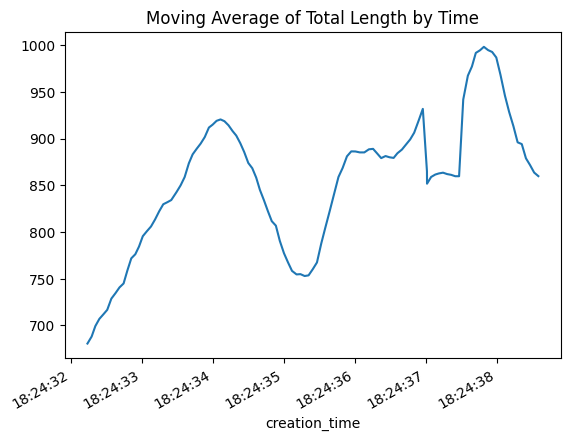

In [13]:
moving_average(total_length_per_time, 10).plot(title='Moving Average of Total Length by Time')

<Axes: xlabel='creation_time'>

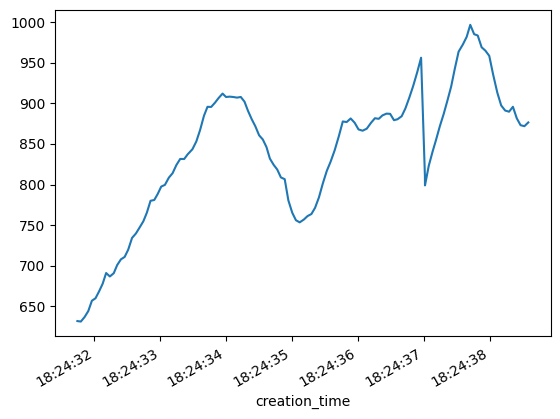

In [14]:
exponential_smoothing(total_length_per_time, 0.2).plot()

<Axes: xlabel='creation_time'>

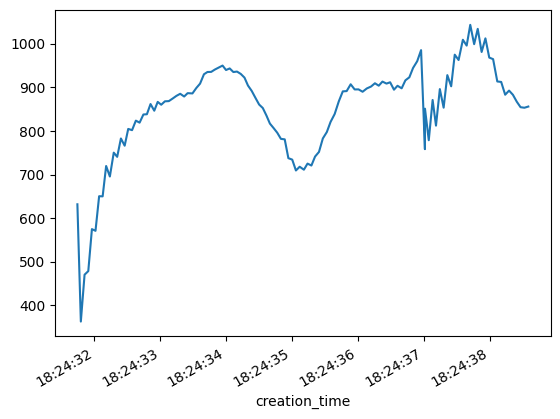

In [15]:
triple_exponential_smoothing(total_length_per_time, 0.1, 0.2, 0.2, 2).plot()

In [17]:
import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(x=total_length_per_time.index, 
                    y=moving_average(total_length_per_time, 10), 
                    mode = 'lines', 
                    name = 'Moving Average')
trace2 = go.Scatter(x=total_length_per_time.index,
                    y=exponential_smoothing(total_length_per_time, 0.2),
                    mode = 'lines',
                    name = 'Exponential Smoothing')
trace3 = go.Scatter(x=total_length_per_time.index,
                    y=triple_exponential_smoothing(total_length_per_time, 0.1, 0.2, 0.2, 2),
                    mode = 'lines',
                    name = 'Triple Exponential Smoothing')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)

# Show figure
fig.show()


In [18]:
import random
# Define the calculate_metric function here
def calculate_metric(total_length_per_time, smoothed_data):
    """
    Calculate the performance metric between the original data and the smoothed data.

    Args:
        total_length_per_time (pd.Series): Original data
        smoothed_data (pd.Series): Smoothed data

    Returns:
        float: Performance metric
    """
    # Calculate the mean squared error between the original data and the smoothed data
    mse = ((total_length_per_time - smoothed_data) ** 2).mean()

    return mse

def validate_threshold(total_length_per_time, alpha_range, beta_range, gamma_range, seasonality_period):
    best_threshold = None

    
    best_metric = float('-inf')

    for alpha in tqdm(alpha_range, desc="Alpha"):
        for beta in tqdm(beta_range, desc="Beta"):
            for gamma in gamma_range:
                # Apply triple exponential smoothing with the current parameters
                smoothed_data = triple_exponential_smoothing(total_length_per_time, alpha, beta, gamma, seasonality_period)

                # Calculate the performance metric (e.g., mean squared error)
                metric = calculate_metric(total_length_per_time, smoothed_data)

                # Update the best threshold and metric if necessary
                if metric > best_metric:
                    best_metric = metric
                    best_threshold = (alpha, beta, gamma)

    return best_threshold, best_metric

# Define the ranges for alpha, beta, gamma
alpha_range = [0.1, 0.2, 0.3]
beta_range = [0.2, 0.4, 0.6]
gamma_range = [0.2, 0.4, 0.6]

# Define the ranges for alpha, beta, gamma
alpha_range = [random.uniform(0.1, 0.3) for _ in range(10)]
beta_range = [random.uniform(0.2, 0.6) for _ in range(10)]
gamma_range = [random.uniform(0.2, 0.6) for _ in range(10)]

# Set the seasonality period
seasonality_period = 2

# Call the validate_threshold function
best_threshold, best_metric = validate_threshold(total_length_per_time, alpha_range, beta_range, gamma_range, seasonality_period)

# Print the best threshold and metric
print("Best Threshold:", best_threshold)
print("Best Metric:", best_metric)


Alpha: 100%|██████████| 10/10 [03:29<00:00, 20.92s/it]

Best Threshold: (0.10714188768696256, 0.572566394265827, 0.20610619933703714)
Best Metric: 78921.28288770313


In [19]:
import plotly.graph_objects as go

# Apply triple exponential smoothing with the best threshold
smoothed_data = triple_exponential_smoothing(total_length_per_time, best_threshold[0], best_threshold[1], best_threshold[2], seasonality_period)

# Create a trace for the original data
trace1 = go.Scatter(x=total_length_per_time.index, y=total_length_per_time, mode='lines', name='Original Data')

# Create a trace for the smoothed data
trace2 = go.Scatter(x=total_length_per_time.index, y=smoothed_data, mode='lines', name='Smoothed Data')

# Create the figure
fig = go.Figure()

# Add the traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Set the title and axis labels
fig.update_layout(title='Triple Exponential Smoothing with Optimal Parameters',
                  xaxis_title='Time',
                  yaxis_title='Data')

# Show the figure
fig.show()